<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Machine Vision Learning
</font>
<hr/>
<font color="#800080" size=5>
LAB 8 : Optical flow
<br>
</font>
<font size=5>
Instructor: Dr. H. Mohammad Zadeh
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
</font>

</div></font>

In [1]:
Name = "Ali Sadeghian"
SN = "400101464"

## Introduction


**A Journey Through Optical Flow: Understanding Motion in Visual Scenes**  

The study of optical flow, the perceived motion of objects or features in a visual scene, has been a cornerstone of computer vision and motion analysis. Rooted in early theories of visual perception, optical flow has evolved into a sophisticated computational tool, enabling applications like video stabilization, object tracking, and action recognition.  

Our exploration of optical flow stemmed from a need to analyze temporal changes within video data. By examining masked and resized video frames representing different emotional expressions (happy and surprised), we began by computing **Histograms of Oriented Gradients (HOG)**, which captured spatial structure effectively. These descriptors formed the basis for classification using logistic regression, random forest, and support vector machines.  

However, the static nature of HOG inspired a deeper dive into motion dynamics. Optical flow became a natural extension, allowing us to focus on frame-to-frame changes. Unlike static descriptors, optical flow emphasizes velocity patterns, offering a richer representation of dynamic events.  

**A Brief History**  

The origins of optical flow trace back to the pioneering work of Horn and Schunck in the 1980s, which framed optical flow as a dense, global optimization problem. This laid the foundation for numerous methods, including the **Lucas-Kanade** approach, which introduced local windowed solutions for computational efficiency. Over the decades, advancements have incorporated feature tracking (e.g., Shi-Tomasi Good Features to Track), dense flow estimation, and deep learning-based flow estimation methods like FlowNet.  

Through our project, we aimed to connect historical methods with modern classification challenges. Masking regions of interest and resizing frames ensured consistency, while optical flow enriched the dataset by encoding motion. This provided critical insights into motion classification and a foundation for exploring advanced video analysis techniques.  

**Mathematical Review of Optical Flow (Lucas-Kanade Method)**

Optical flow refers to the apparent motion of objects, surfaces, or edges within a visual scene. The **Lucas-Kanade** method computes optical flow under the assumption of brightness constancy, spatial coherence, and small motion between frames. Mathematically, this is expressed as:

$$
I(x, y, t) = I(x + \Delta x, y + \Delta y, t + \Delta t)
$$

Where:
- $I(x, y, t)$ is the pixel intensity at position $(x, y)$ in frame $t$,
- $(\Delta x, \Delta y)$ represent the displacement between consecutive frames.

Expanding using a Taylor series and ignoring higher-order terms:

$$
\frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} v + \frac{\partial I}{\partial t} = 0
$$

Here:
- $\frac{\partial I}{\partial x}$ and $\frac{\partial I}{\partial y}$ are spatial gradients,
- $\frac{\partial I}{\partial t}$ is the temporal gradient,
- $u$ and $v$ are the horizontal and vertical components of the flow.

The Lucas-Kanade method solves this equation locally using a small window ($W$) of pixels, assuming constant flow within the window. This leads to a linear system:

$$
A v = b
$$

Where:
- $A = \begin{bmatrix} \frac{\partial I}{\partial x} & \frac{\partial I}{\partial y} \end{bmatrix}$,
- $v = \begin{bmatrix} u \\ v \end{bmatrix}$,
- $b = -\frac{\partial I}{\partial t}$.

By minimizing the error, $v$ is computed for every window in the frame.

## part A

### Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image, ImageDraw
import random
import cv2

### Dense Optical Flow 

The **dense optical flow** technique, implemented using OpenCV’s `cv2.calcOpticalFlowFarneback`, computes the motion vector for every pixel in the frame. It does not assume sparse features but calculates the flow for the entire image.

##### Function Used: `cv2.calcOpticalFlowFarneback`
This function estimates dense optical flow based on the Farneback algorithm, using polynomial expansion for neighboring pixels. The function parameters are:

- **prev_gray**: The first grayscale frame.
- **gray**: The second grayscale frame.
- **pyr_scale (0.5)**: Scaling between image pyramids (used for coarse-to-fine processing).
- **levels (3)**: The number of pyramid layers.
- **winsize (15)**: The averaging window size; larger values detect large motions but may smooth small details.
- **iterations (3)**: The number of iterations per pyramid level.
- **poly_n (5)**: The size of the pixel neighborhood for polynomial expansion.
- **poly_sigma (1.2)**: Standard deviation of the Gaussian used in polynomial expansion.
- **flags (0)**: Operation flags.

#### Visualization Using HSV
To represent optical flow visually:
1. **Angle**: Encodes the flow direction, mapped to the Hue channel in the HSV color space.
2. **Magnitude**: Encodes the strength of motion, mapped to the Value channel.
3. The Saturation channel is set to its maximum to enhance colors.

In [ ]:
cap = cv2.VideoCapture("me.mp4")
if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('dense_optical_flow.avi', fourcc, fps, (frame_width, frame_height))

# Initialize the first frame
ret, first_frame = cap.read()
if not ret:
    print("Error: Cannot read video file.")
    cap.release()
    exit()

prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# HSV map for visualization
hsv = np.zeros_like(first_frame)
hsv[..., 1] = 255

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate Dense Optical Flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Compute magnitude and angle
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = angle * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Convert HSV to RGB and save/display
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    out.write(rgb_flow)  # Save the frame to the output video
    cv2.imshow("Dense Optical Flow", rgb_flow)

    # Update the previous frame
    prev_gray = gray

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

### Sparse Optical Flow with Good Features Tracking

In this implementation, the **sparse optical flow** method is used in combination with feature detection to track distinct points across video frames. The method identifies a set of "good features" to track and computes their motion using the **Lucas-Kanade Optical Flow** algorithm.

---

#### Feature Detection with `cv2.goodFeaturesToTrack`

The **`cv2.goodFeaturesToTrack`** function is a key part of the process, as it identifies points in the image that are well-suited for tracking over time. These points are typically corners or sharp edges, which are easier to locate consistently across frames because they have distinct local patterns.

##### Why Corners and Edges?
Corners are ideal for tracking because they exhibit strong variations in intensity in two directions (e.g., x and y). This makes them robust to small movements or transformations in the image, as they can still be recognized in subsequent frames.

For example:
- Flat regions (e.g., walls) lack distinct intensity changes and are not good for tracking.
- Straight edges (e.g., a line) have strong intensity variation in one direction but not the other, making tracking along the edge unreliable.
- Corners (e.g., at the intersection of two edges) show significant changes in intensity in both directions, making them easily identifiable across frames.

##### How `cv2.goodFeaturesToTrack` Works
The function uses the **Shi-Tomasi corner detection algorithm** to find these good features. Shi-Tomasi improves upon the Harris Corner Detector by selecting points with the highest "corner response" values based on eigenvalues of the image gradient matrix.

1. **Image Gradients**:
   - The function calculates the gradient of pixel intensities in the image.
   - It forms a structure matrix from these gradients to represent how the intensity varies locally.

2. **Eigenvalue Calculation**:
   - Eigenvalues of the structure matrix represent the strength of variation in two perpendicular directions at a point.
   - Shi-Tomasi considers the smaller eigenvalue as the corner response. This ensures that the point has sufficient variation in both directions.

3. **Corner Selection**:
   - Points with corner responses above a certain threshold are considered.
   - The function further refines the selection to avoid clustering of points that are too close (based on `minDistance`).

---

##### Parameters in `cv2.goodFeaturesToTrack`

1. **`maxCorners`**: 
   - This limits the maximum number of points to detect. For example, setting `maxCorners=100` ensures the function detects up to 100 points, prioritizing those with the strongest corner response.
   
2. **`qualityLevel`**:
   - This sets a threshold for corner quality. It is expressed as a fraction of the best corner response. 
   - For example, `qualityLevel=0.3` means the function will only select corners whose response is at least 30% of the best corner's response.
   
3. **`minDistance`**:
   - This specifies the minimum Euclidean distance (in pixels) allowed between any two detected points. 
   - It ensures the points are spread out rather than clustered together, improving tracking performance.

4. **`blockSize`**:
   - The size of the neighborhood (in pixels) considered when calculating gradients and corner responses. A larger block size captures broader features, while a smaller block size focuses on finer details.

---

#### Motion Estimation: Lucas-Kanade Optical Flow

Once the features are detected, the motion of these points is tracked across frames using the **Lucas-Kanade Optical Flow** algorithm. This algorithm computes the displacement ($u, v$) of each point between consecutive frames by minimizing the brightness constancy equation locally:

$$
\frac{\partial I}{\partial x} u + \frac{\partial I}{\partial y} v + \frac{\partial I}{\partial t} = 0
$$

##### Parameters in `cv2.calcOpticalFlowPyrLK`:
- **`winSize=(15, 15)`**: Size of the search window used for each feature point.
- **`maxLevel=2`**: Number of pyramid levels for coarse-to-fine refinement.
- **`criteria`**: Termination criteria, which stops the iteration when either:
  - The number of iterations exceeds 10 (`cv2.TERM_CRITERIA_COUNT`).
  - The motion estimate changes by less than 0.03 (`cv2.TERM_CRITERIA_EPS`).

The algorithm calculates motion for each feature point and provides:
- **`next_points`**: New positions of the tracked points.
- **`status`**: A binary array indicating whether a point was successfully tracked.
- **`error`**: The tracking error for each point.

---

#### Visualizing Sparse Optical Flow

To make the motion visible:
1. **Track Lines**: For each feature point, a line is drawn between its old and new position.
2. **Circles**: A circle marks the current position of each tracked point.
3. **Overlay**: The mask containing lines is overlaid on the original frame to visualize the trajectory of motion.

##### Implementation Details:
- **Initialization**:
  - The first frame is converted to grayscale for detecting features.
  - A blank mask is created for drawing the trajectories.
- **Frame Processing**:
  - Each frame is converted to grayscale for motion calculation.
  - The motion of the tracked points is computed using `cv2.calcOpticalFlowPyrLK`.
  - Points that are successfully tracked (`status == 1`) are used for visualization.
  - Lines and circles are drawn to represent motion.
- **Dynamic Update**:
  - The mask accumulates motion lines to visualize the entire trajectory.
  - Tracked points and grayscale frames are updated for the next iteration.

In [ ]:
# Parameters for detecting features to track
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Parameters for Lucas-Kanade Optical Flow
lk_params = dict(winSize=(15, 15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Video capture
cap = cv2.VideoCapture("me.mp4")
if not cap.isOpened():
    print("Error: Cannot open video file.")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Output video writer
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, fps, (frame_width, frame_height))

# Read the first frame
ret, first_frame = cap.read()
if not ret:
    print("Error: Cannot read video file.")
    cap.release()
    exit()

# Convert to grayscale
prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)

# Detect initial features to track
prev_points = cv2.goodFeaturesToTrack(prev_gray, mask=None, **feature_params)
if prev_points is None or len(prev_points) == 0:
    print("No features found to track.")
    cap.release()
    exit()

# Create a mask image for drawing
mask = np.zeros_like(first_frame)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None, **lk_params)

    # Ensure points are not empty
    if next_points is None or len(next_points) == 0:
        print("No more points to track.")
        break

    # Select good points
    good_new = next_points[status == 1]
    good_old = prev_points[status == 1]

    # Draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = map(int, new.ravel())  # Convert to integers
        c, d = map(int, old.ravel())  # Convert to integers
        mask = cv2.line(mask, (a, b), (c, d), (0, 255, 0), 2)
        frame = cv2.circle(frame, (a, b), 5, (0, 255, 0), -1)

    # Overlay the original frame with the mask
    img = cv2.add(frame, mask)

    # Write the frame to the output file
    out.write(img)

    # Display the result
    cv2.imshow("Sparse Optical Flow", img)

    # Update previous frame and points
    prev_gray = gray.copy()
    prev_points = good_new.reshape(-1, 1, 2)

    # Exit on pressing 'q'
    if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()

## part B

### Libraries

In [30]:
import os
import zipfile
from PIL import Image, ImageDraw
import random
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### Reading data and Preprocessing

Our dataset consists of videos representing two distinct emotional reactions: *happy* and *surprised*. Each video comprises multiple grayscale frames. The steps for data preparation included:

1. **Data Loading**: We structured the dataset as a list, where each element represents a video, and each video contains its respective frames. 
2. **Preprocessing**:
    - Frames were cropped to remove unnecessary margins using a fixed percentage-based cropping approach.
    - Images were resized to standardize dimensions while maintaining the aspect ratio for computational efficiency.
    - An elliptical mask was applied to focus on the central region of interest, further removing irrelevant background information.

These steps ensured consistency and relevance in the input data for subsequent analysis.


In [36]:
def extract_zip(zip_file_path, extract_to='.'):

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

zip_file_path = 'data_set_video.zip'  # Path to the ZIP file
extract_to = './extracted_data'       # Directory to extract to

# Extract the ZIP file
extract_zip(zip_file_path, extract_to)

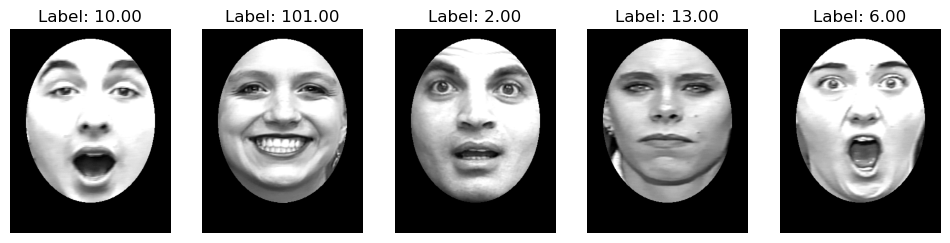

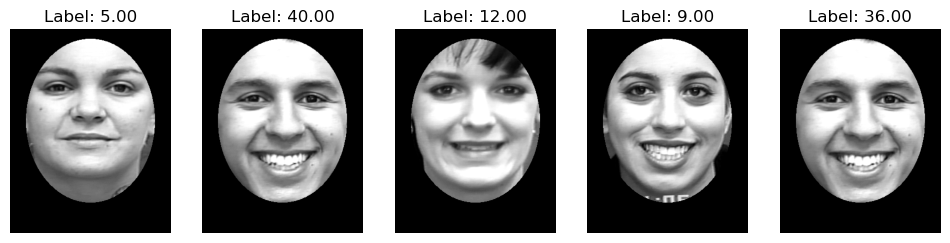

In [37]:
def load_images_from_folders(data_directory):

    folder_images_list = []  # List to hold images from each folder separately

    # Step 1: Read all images as grayscale and store in a list for each folder
    for folder_name in sorted(os.listdir(data_directory)):
        folder_path = os.path.join(data_directory, folder_name)
        if os.path.isdir(folder_path):
            images_in_folder = []
            for image_name in sorted(os.listdir(folder_path)):
                image_path = os.path.join(folder_path, image_name)
                # Read the image in grayscale using PIL
                try:
                    with Image.open(image_path) as img:
                        gray_image = img.convert('L')  # Convert to grayscale
                        images_in_folder.append(np.array(gray_image))
                except Exception as e:
                    print(f"Error reading {image_path}: {e}")
            folder_images_list.append(images_in_folder)

    return folder_images_list

def crop_margins(image, a=0.06, b=0.24):
 
    # Calculate the number of pixels to crop from each side
    height, width = image.shape
    row_margin = int(height * a)
    col_margin = int(width * b)

    # Crop the image based on the calculated margins
    cropped_image = image[
        row_margin:height - row_margin,
        col_margin:width - col_margin
    ]
    return cropped_image

def resize_images(folder_images_list, scale=0.5):

    resized_images = []
    for images in folder_images_list:
        resized_folder_images = []
        for img in images:
            # Crop margins before resizing
            cropped_image = crop_margins(img)
            new_size = (int(cropped_image.shape[1] * scale), int(cropped_image.shape[0] * scale))
            resized_image = np.array(Image.fromarray(cropped_image).resize(new_size, Image.LANCZOS))
            resized_folder_images.append(resized_image)
        resized_images.append(resized_folder_images)
    return resized_images

def create_elliptical_mask(image_shape, height_factor=0.8, width_factor=0.8, center_height_bias=-20, center_width_bias=0):

    height, width = image_shape
    mask = Image.new('L', (width, height), 0)
    draw = ImageDraw.Draw(mask)

    # Calculate the center of the image with biases
    center_y = height / 2 + center_height_bias
    center_x = width / 2 + center_width_bias

    # Calculate the bounding box for the ellipse
    ellipse_bbox = [
        (center_x - (width * width_factor) / 2, center_y - (height * height_factor) / 2),
        (center_x + (width * width_factor) / 2, center_y + (height * height_factor) / 2)
    ]
    
    draw.ellipse(ellipse_bbox, fill=255)
    return np.array(mask)

def apply_mask_to_images(folder_images_list, mask):
  
    masked_images = []
    for images in folder_images_list:
        masked_folder_images = []
        for img in images:
            masked_image = img * (mask / 255)  # Normalize mask to [0,1] range
            masked_folder_images.append(masked_image.astype(np.uint8))
        masked_images.append(masked_folder_images)
    return masked_images

def plot_random_images_with_labels(folder_images_list, labels, n=5):

    plt.figure(figsize=(12, 6))
    total_images = sum(len(images) for images in folder_images_list)
    random_indices = random.sample(range(total_images), n)

    # Flatten the list to access images linearly
    flattened_images = [img for folder in folder_images_list for img in folder]
    flattened_labels = [label for label_list in labels for label in label_list]

    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(flattened_images[idx], cmap='gray')
        plt.title(f'Label: {flattened_labels[idx]:.2f}')
        plt.axis('off')
    plt.show()


# Define the data directory path
data_directory_s = os.path.join(extract_to, 'surprise videos')
data_directory_h = os.path.join(extract_to, 'happy videos')

# Load images from the folders
folder_images_list_s = load_images_from_folders(data_directory_s)
folder_images_list_h = load_images_from_folders(data_directory_h)

# Resize the images
resized_images_s = resize_images(folder_images_list_s)
resized_images_h = resize_images(folder_images_list_h)

# Create an elliptical mask based on the new image size
sample_shape_s = resized_images_s[0][0].shape  # Use the shape of the first resized image
mask_s = create_elliptical_mask(sample_shape_s)

sample_shape_h = resized_images_h[0][0].shape  # Use the shape of the first resized image
mask_h = create_elliptical_mask(sample_shape_h)

# Apply the mask to the images
masked_images_s = apply_mask_to_images(resized_images_s, mask_s)
masked_images_h = apply_mask_to_images(resized_images_h, mask_h)

# Prepare data for plotting
labels_s = [np.arange(0, len(images) + 1) for images in resized_images_s]
labels_h = [np.arange(0, len(images) + 1) for images in resized_images_h]

# Plot some random masked images with corresponding labels
plot_random_images_with_labels(masked_images_s, labels_s, n=5)
plot_random_images_with_labels(masked_images_h, labels_h, n=5)

### Feature extracting and Training

**Feature Extraction**

To classify videos, we employed **optical flow** as the primary feature extraction technique:
- **Optical Flow**: The motion between consecutive frames was calculated using the **Lucas-Kanade** method, capturing movement patterns.
- **Histogram Representation**:
    - The optical flow angles were quantified into an 8-bin histogram for each frame.
    - For each video, frame-wise histograms were aggregated using two pooling strategies:
        - **Average pooling**: Capturing the mean motion pattern.
        - **Max pooling**: Capturing the most significant motion across frames.
    - This process resulted in a feature vector of 16 bins per video, effectively su

In [38]:
# Prepare labels: 1 for surprise, 0 for happy
labels_s = [1] * len(masked_images_s)
labels_h = [0] * len(masked_images_h)

# Combine and split
videos = masked_images_s + masked_images_h
labels = labels_s + labels_h

X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.3, stratify=labels, random_state=42)

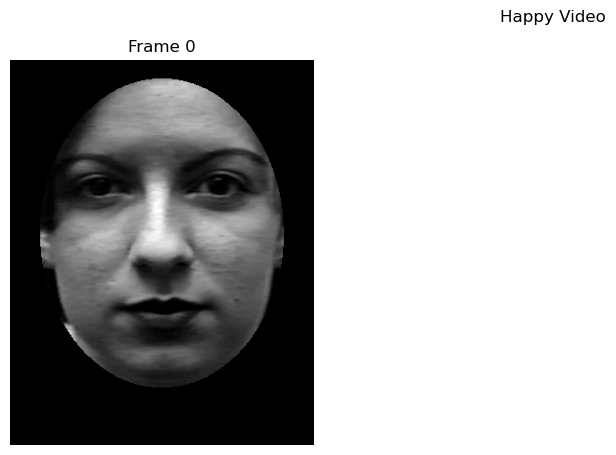

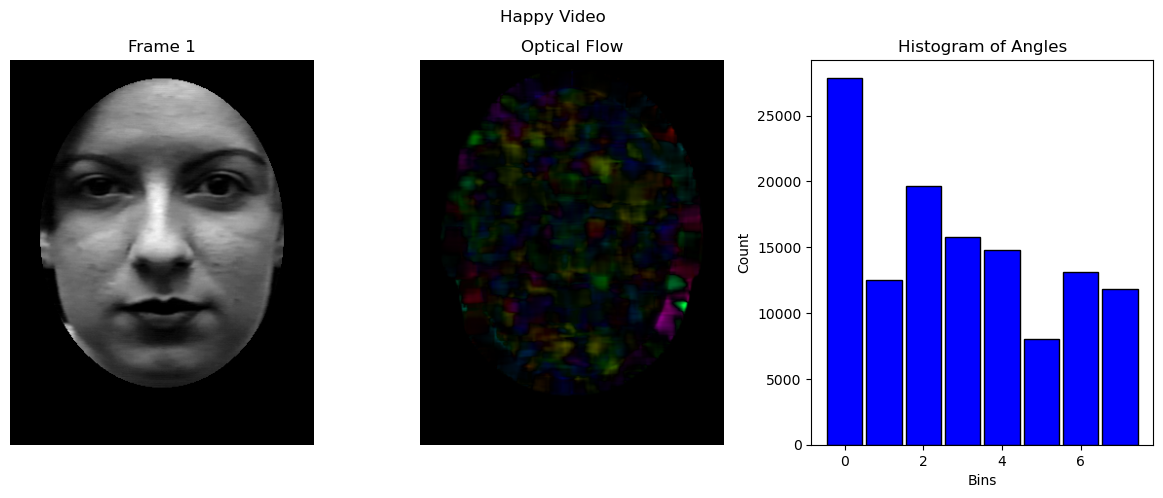

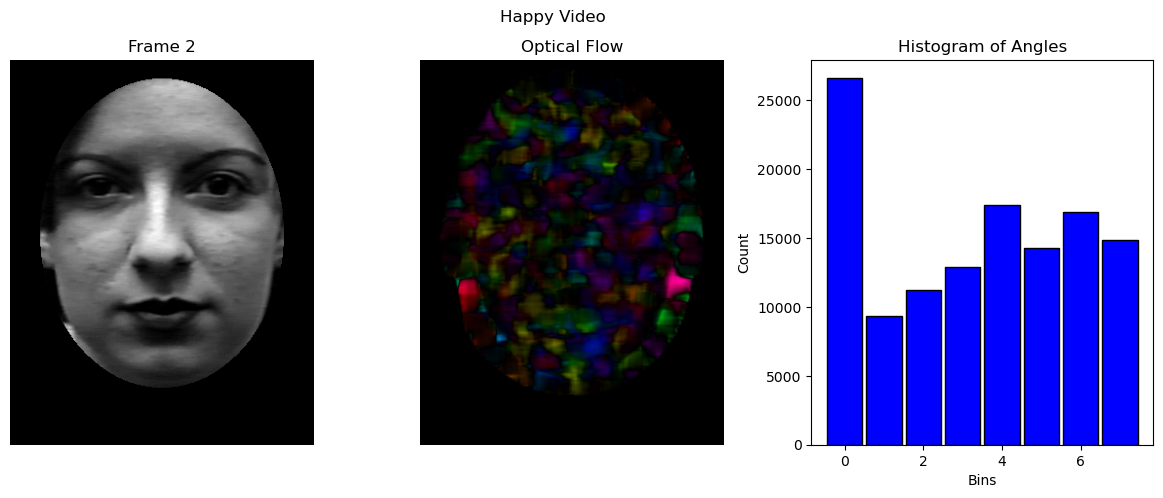

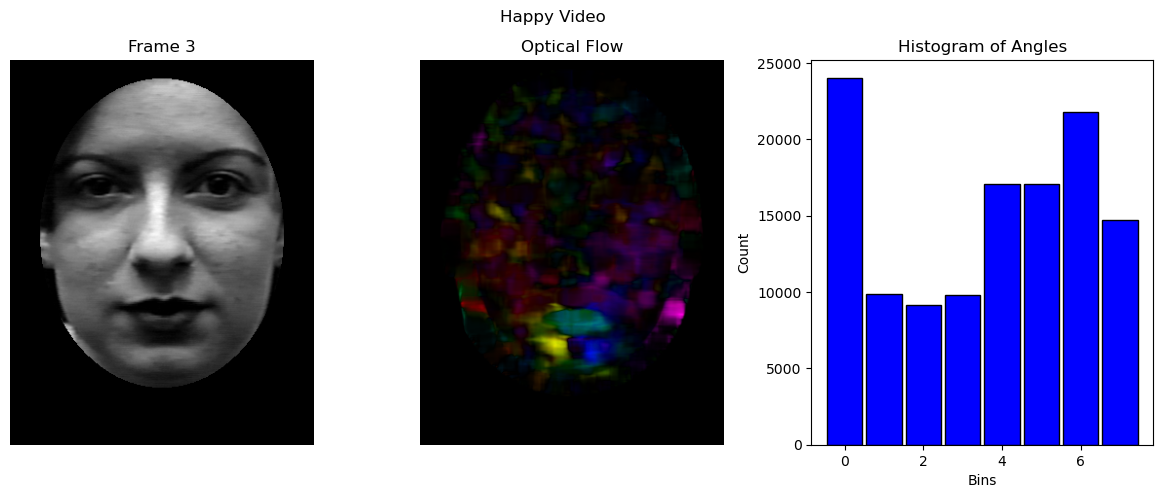

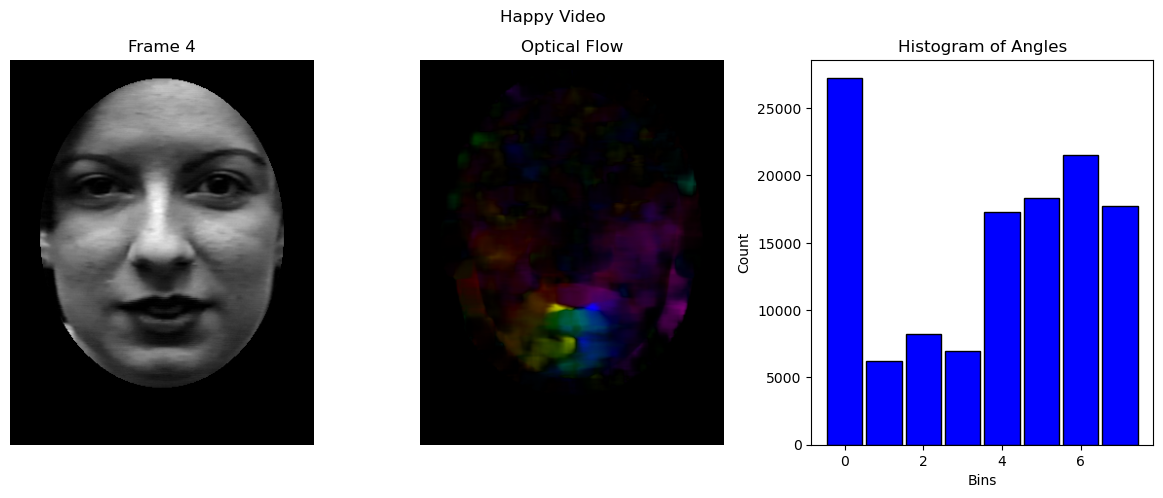

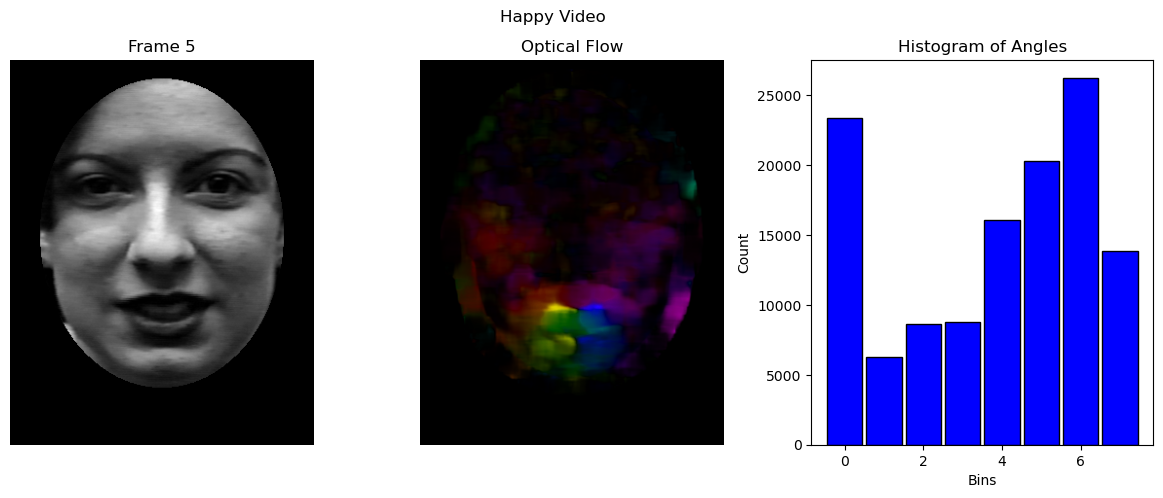

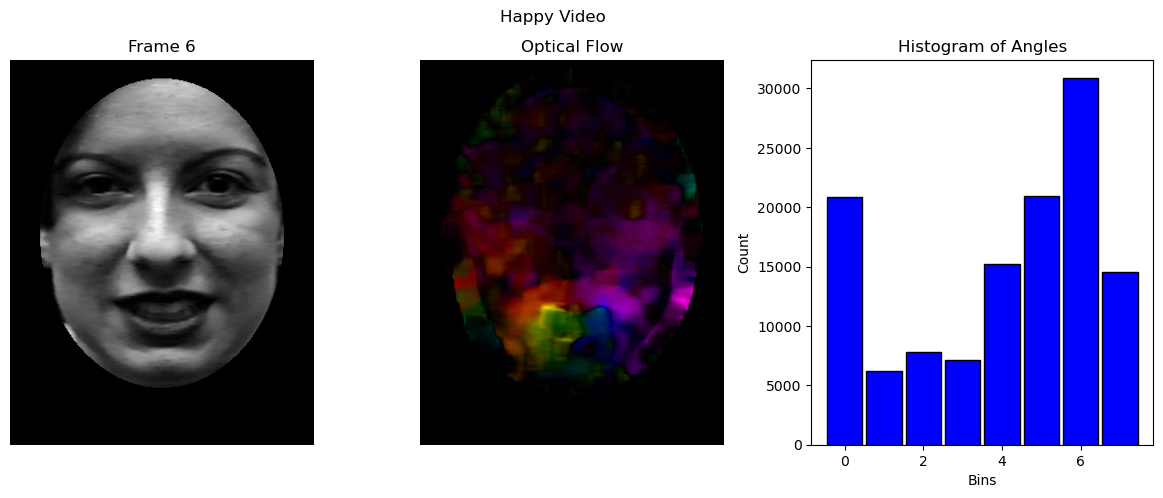

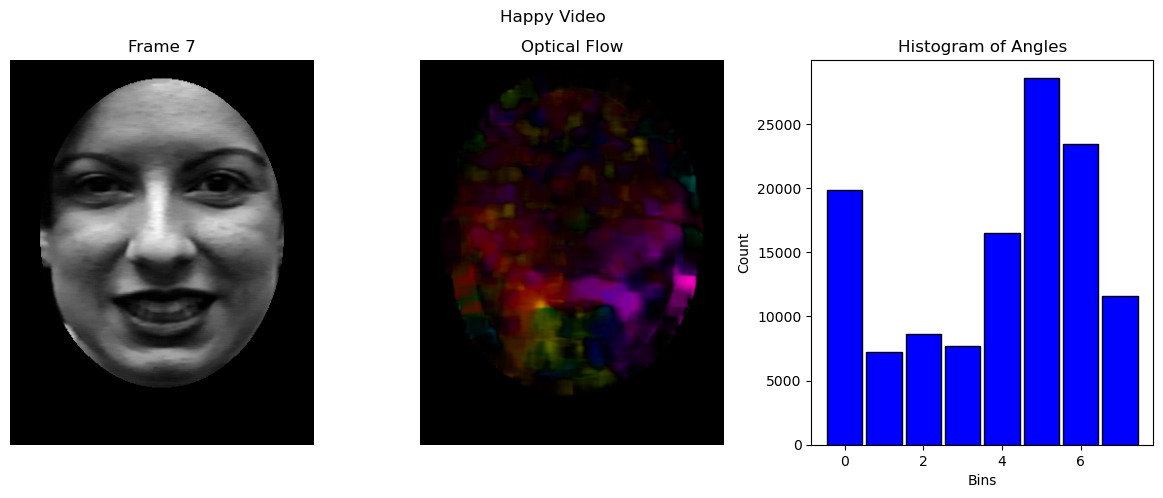

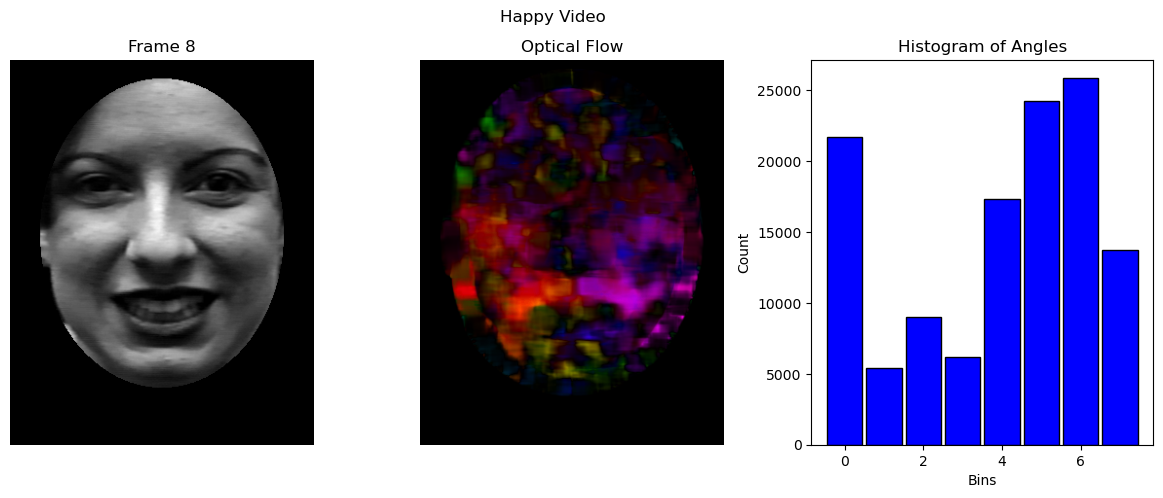

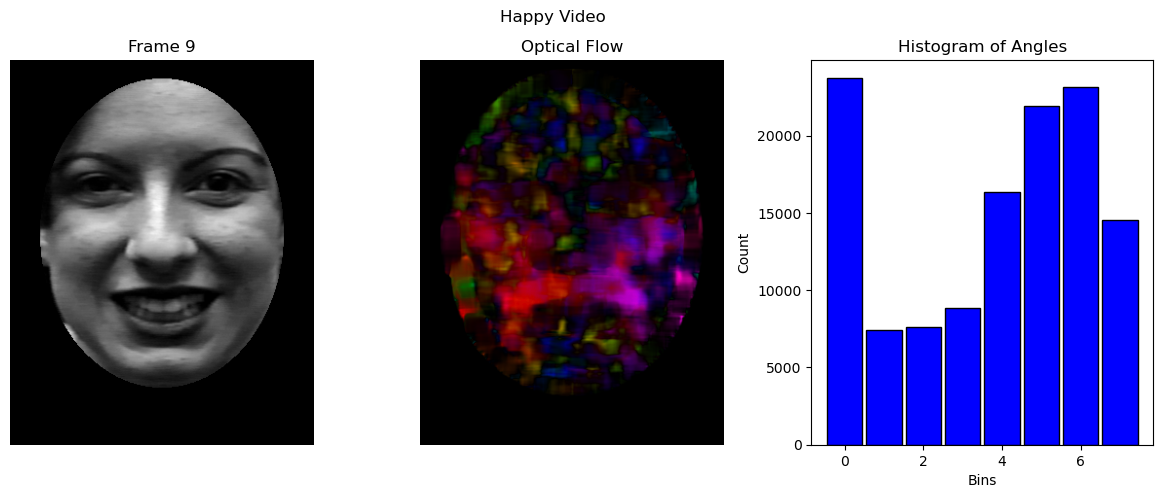

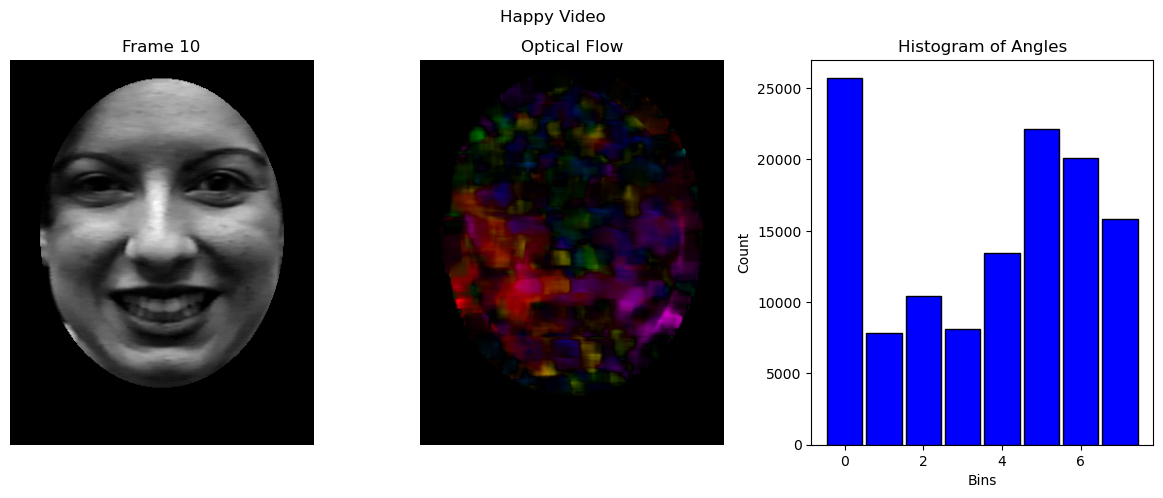

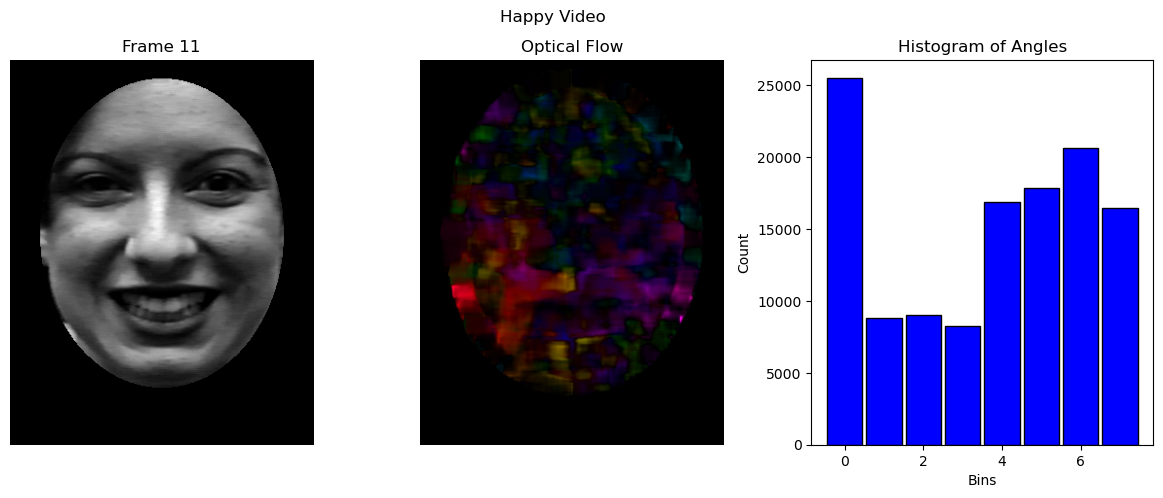

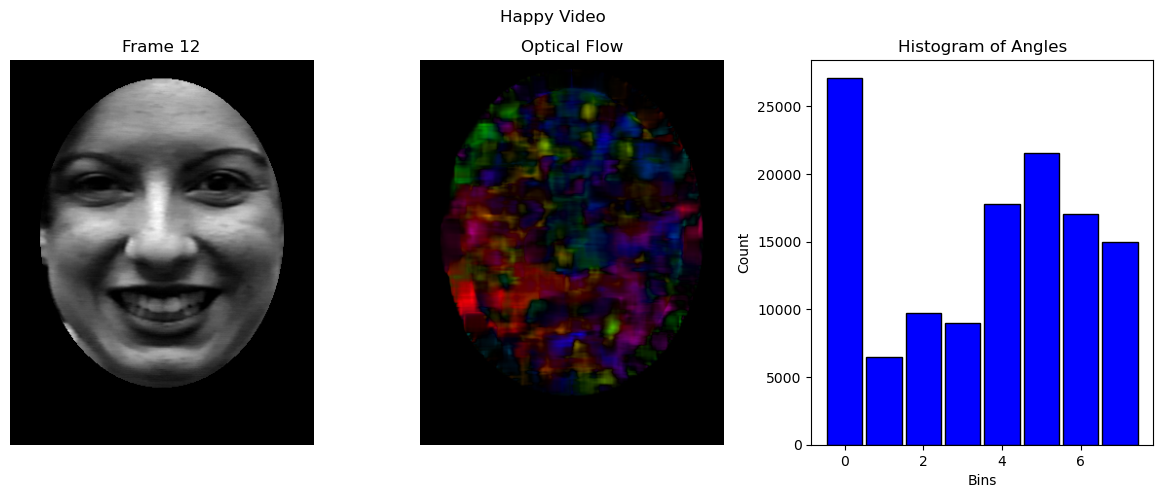

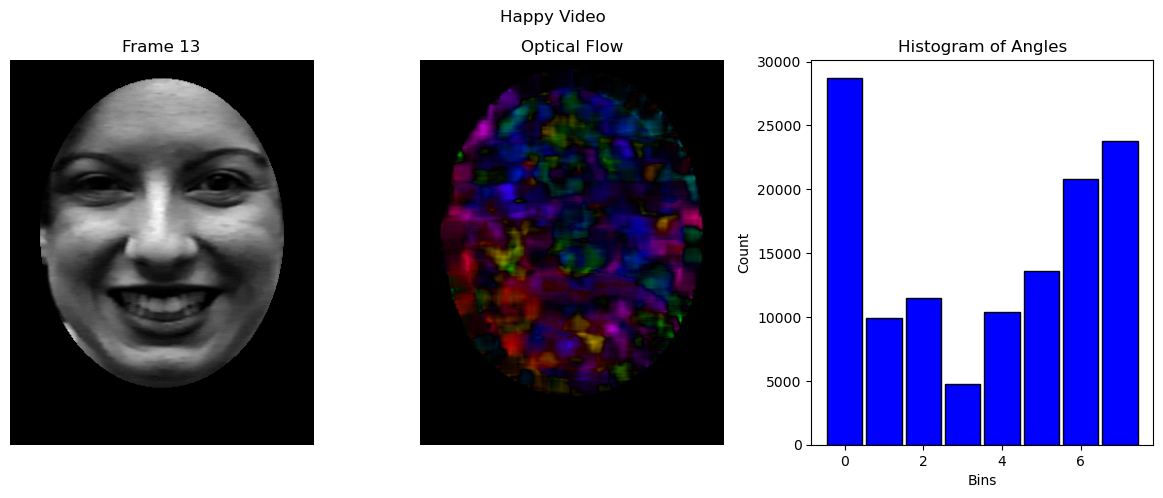

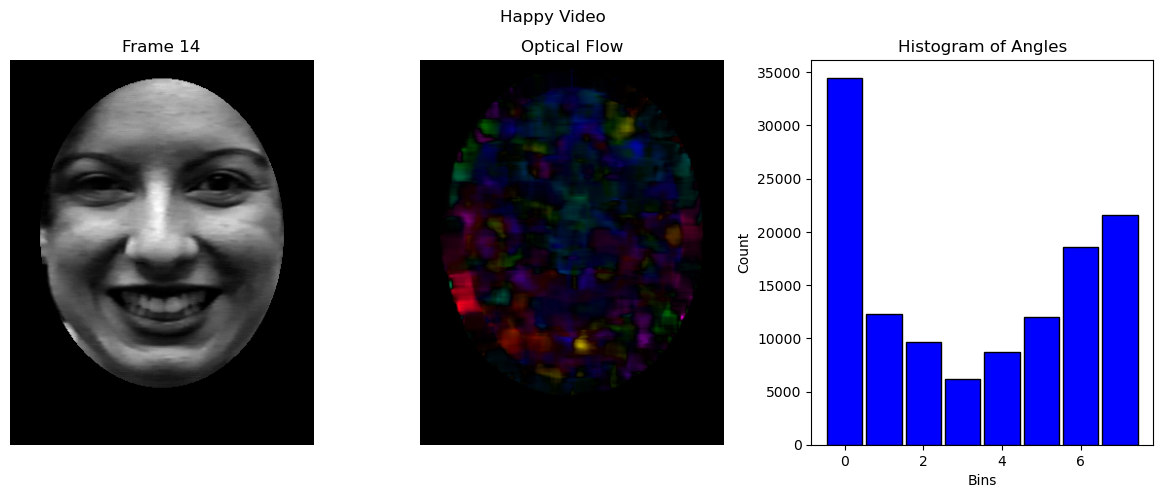

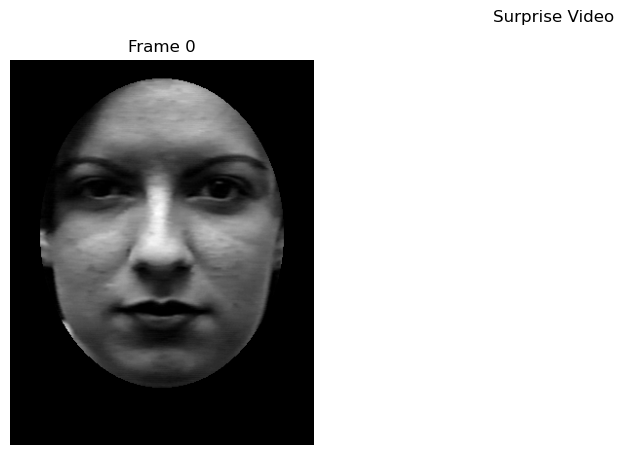

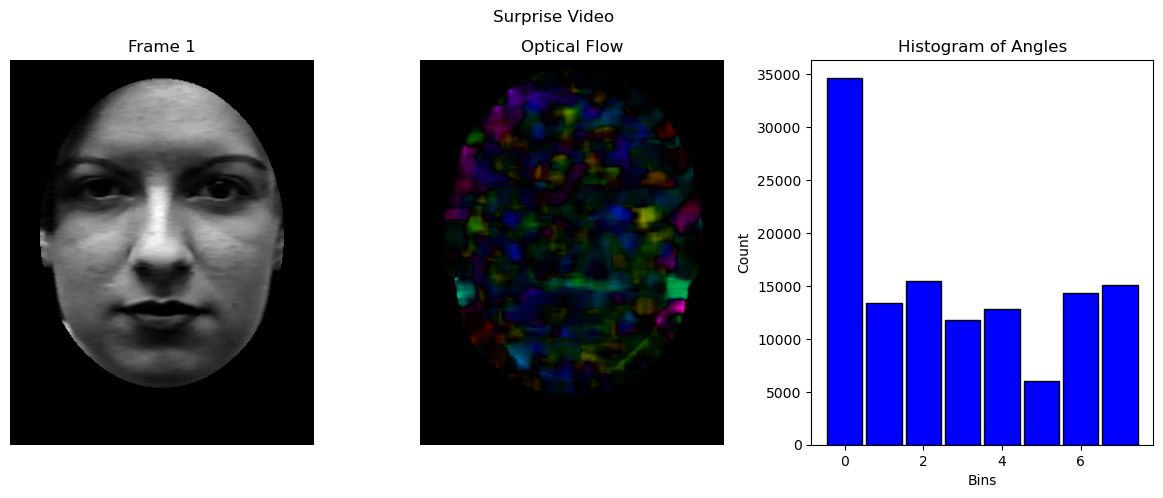

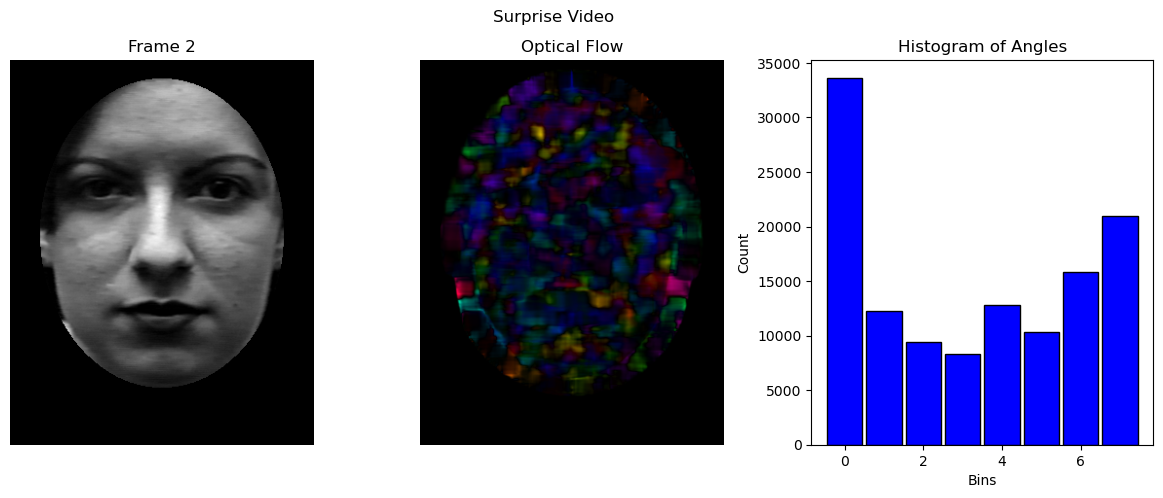

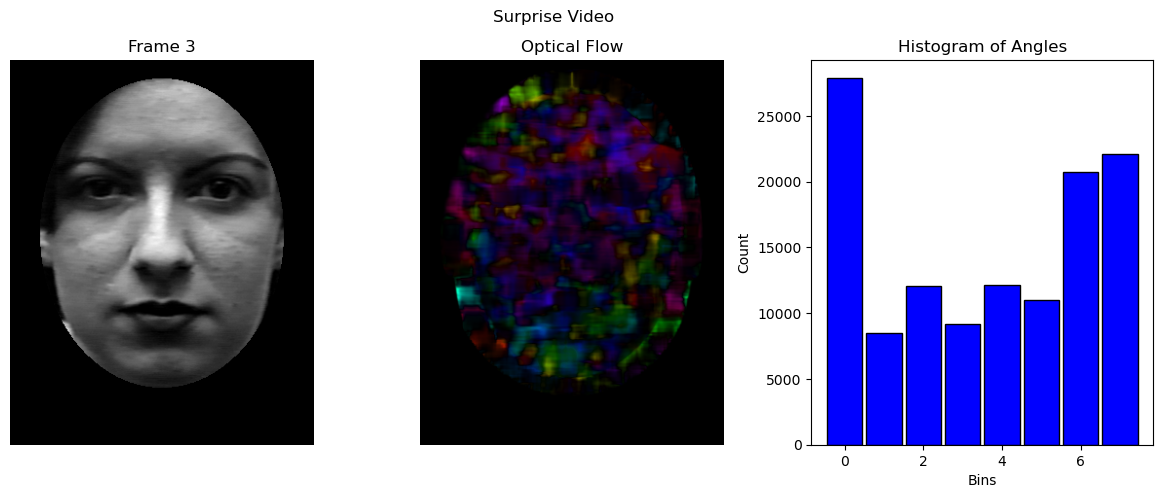

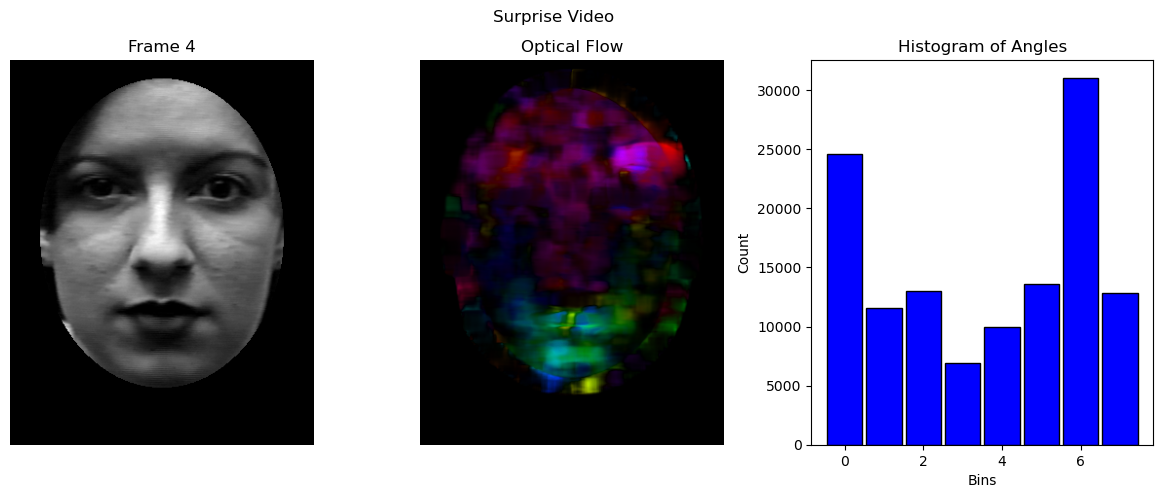

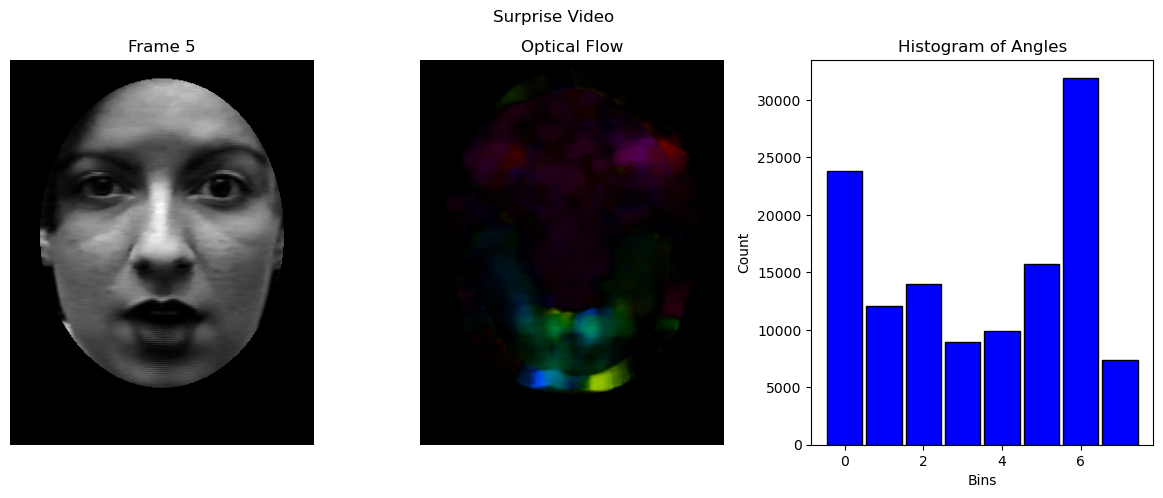

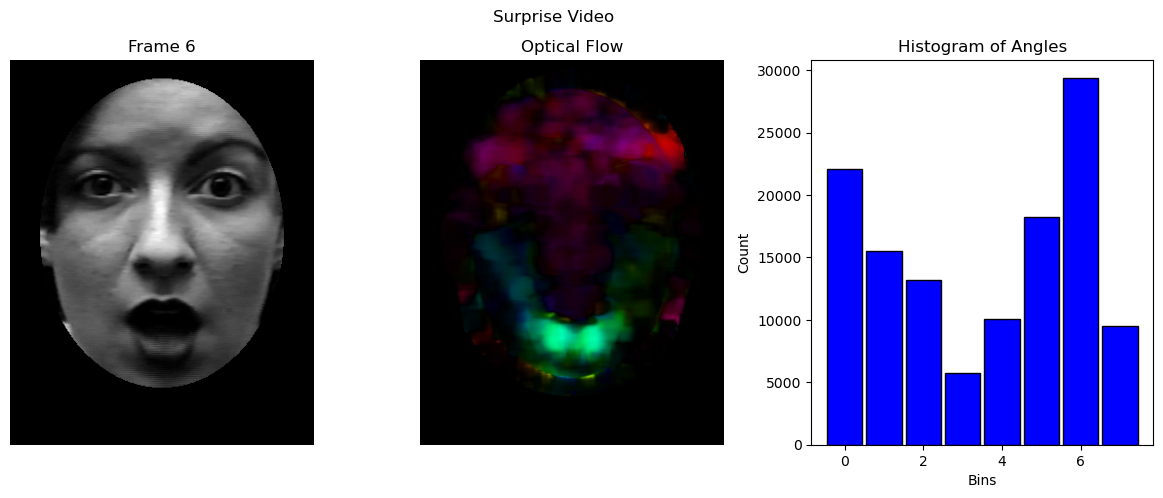

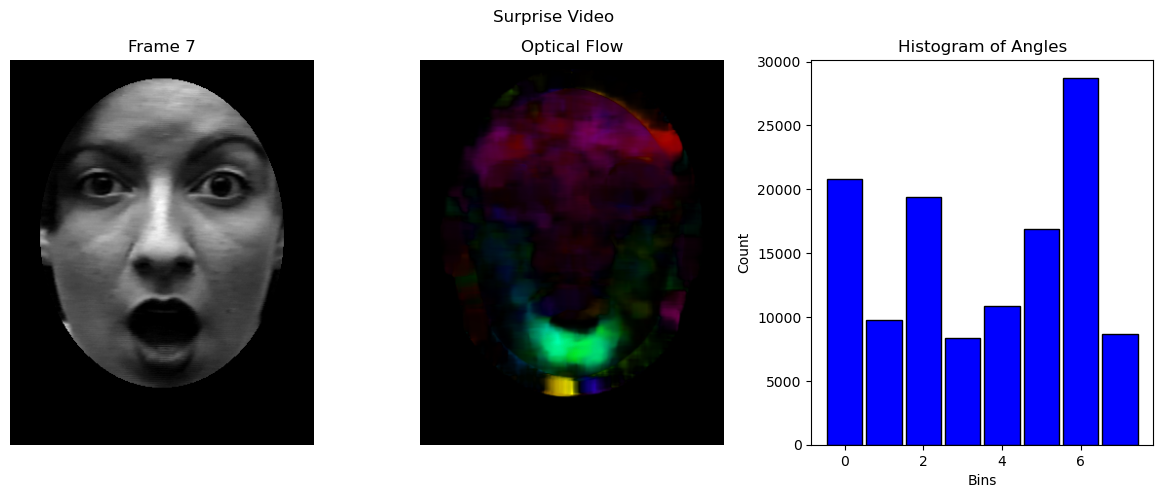

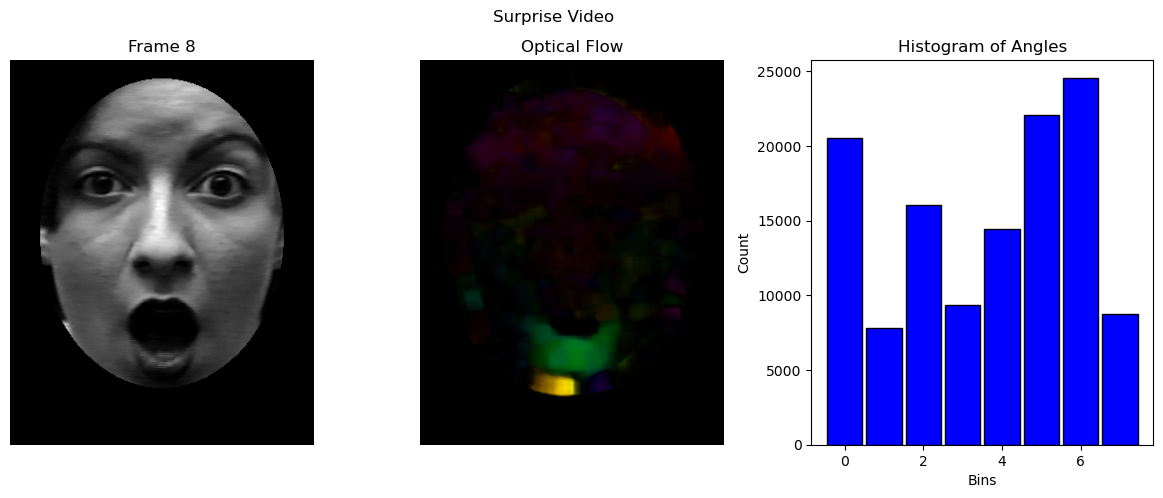

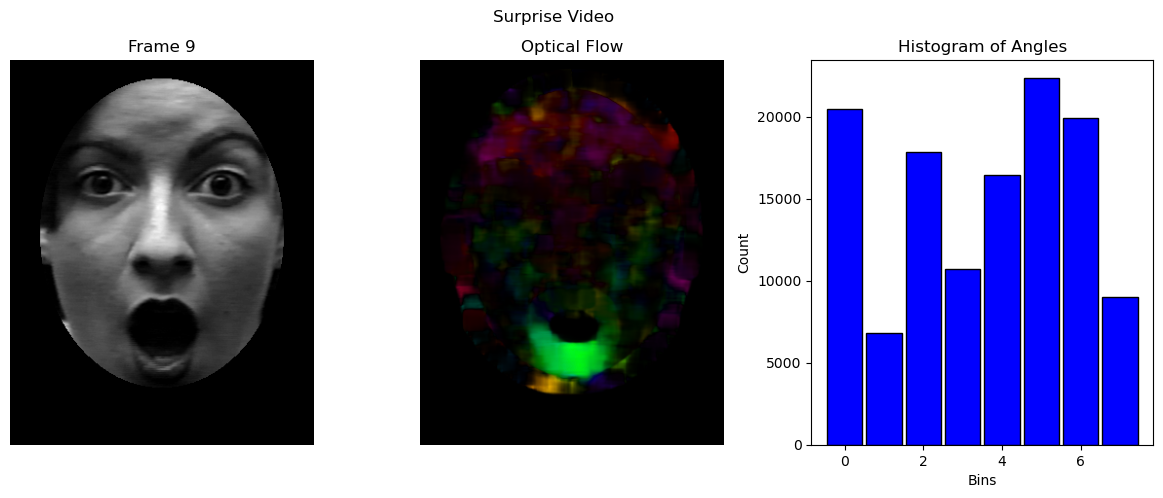

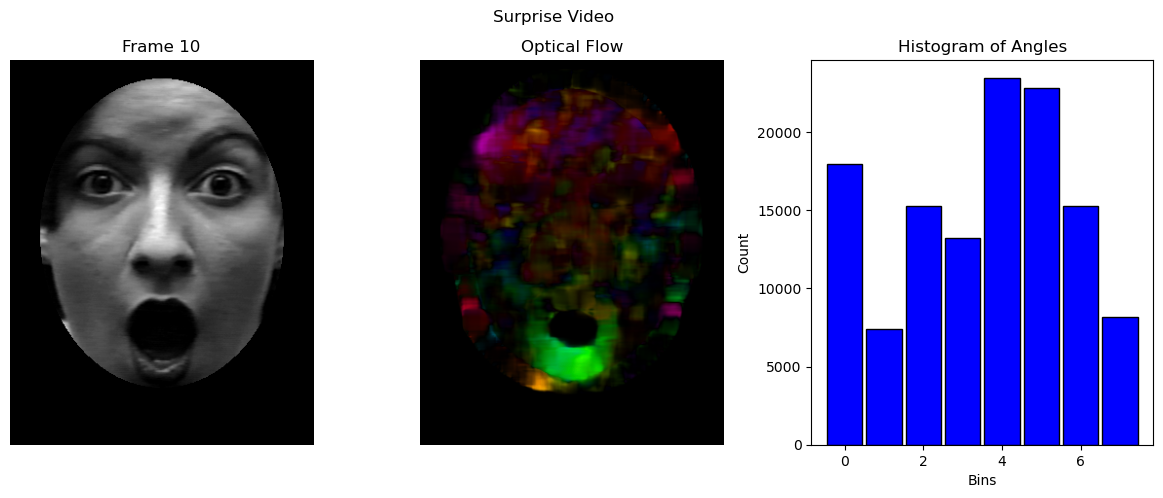

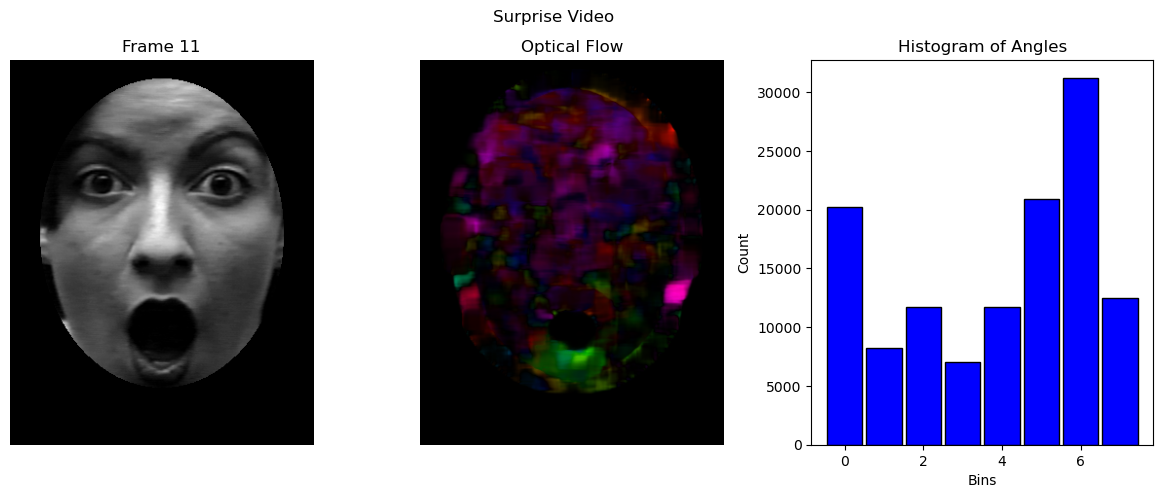

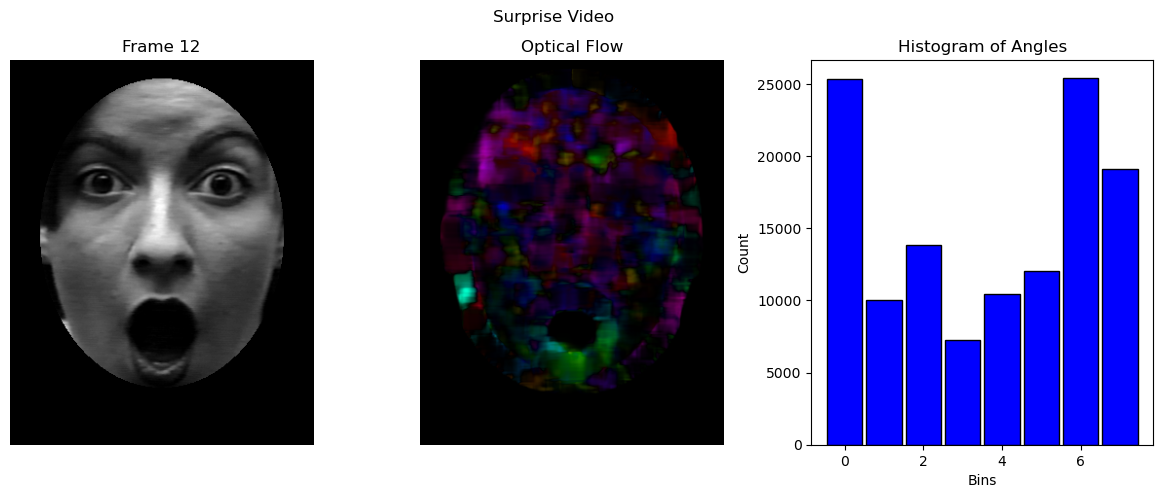

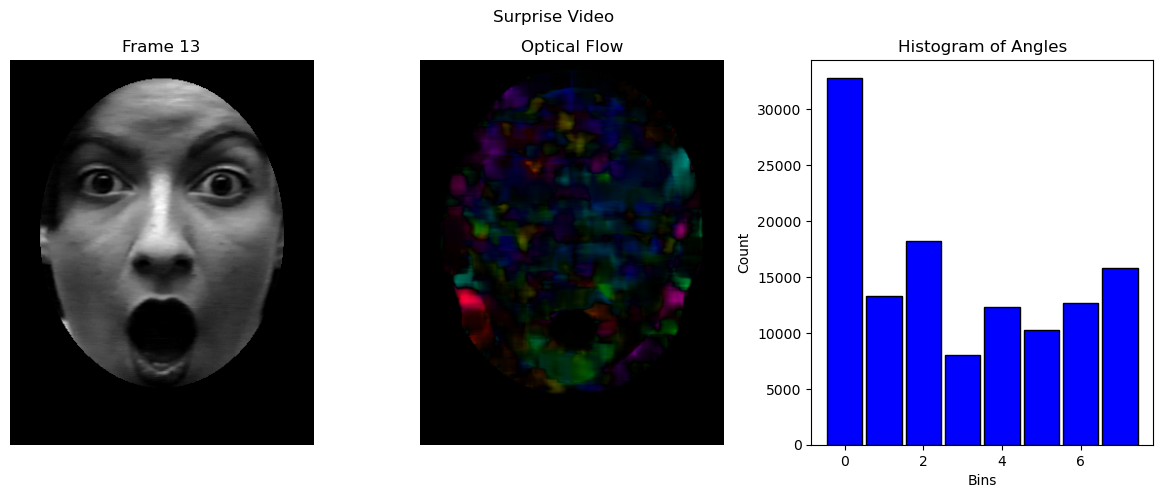

In [39]:
def visualize_optical_flow_and_histogram(video_frames, bins=8, title=""):
    prev_frame = None
    frame_index = 0

    for frame in video_frames:
        plt.figure(figsize=(15, 5))
        
        # Display the current frame
        plt.subplot(1, 3, 1)
        plt.imshow(frame, cmap='gray')
        plt.title(f"Frame {frame_index}")
        plt.axis('off')

        if prev_frame is not None:
            # Calculate optical flow
            flow = cv2.calcOpticalFlowFarneback(prev_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)

            # Visualize optical flow
            hsv = np.zeros_like(cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR))
            hsv[..., 1] = 255
            hsv[..., 0] = angle * 0.5
            hsv[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
            optical_flow_visual = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            plt.subplot(1, 3, 2)
            plt.imshow(optical_flow_visual)
            plt.title("Optical Flow")
            plt.axis('off')

            # Compute histogram for angles
            hist, _ = np.histogram(angle, bins=bins, range=(0, 360))
            
            # Display histogram
            plt.subplot(1, 3, 3)
            plt.bar(range(bins), hist, width=0.9, color='blue', edgecolor='black')
            plt.title("Histogram of Angles")
            plt.xlabel("Bins")
            plt.ylabel("Count")

        plt.suptitle(title)
        plt.show()

        prev_frame = frame
        frame_index += 1

# Select one video from each class
happy_video = masked_images_h[0]  # First video from happy class
surprise_video = masked_images_s[0]  # First video from surprise class

# Visualize for happy video
visualize_optical_flow_and_histogram(happy_video, bins=8, title="Happy Video")

# Visualize for surprise video
visualize_optical_flow_and_histogram(surprise_video, bins=8, title="Surprise Video")

In [40]:
def compute_optical_flow_histograms(video_frames, bins=8):
    histograms = []
    prev_frame = None

    for frame in video_frames:
        if prev_frame is not None:
            # Calculate optical flow
            flow = cv2.calcOpticalFlowFarneback(prev_frame, frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
            
            # Compute histogram for angles
            hist, _ = np.histogram(angle, bins=bins, range=(0, 360))
            histograms.append(hist)
        
        prev_frame = frame
    
    if histograms:
        histograms = np.array(histograms)
        # Aggregate histograms: average and max pooling
        avg_hist = np.mean(histograms, axis=0)
        max_hist = np.max(histograms, axis=0)
        return np.concatenate((avg_hist, max_hist))
    else:
        return np.zeros(2 * bins)  # Handle edge case for single frame videos

# Apply feature extraction to all videos
def extract_features(videos, bins=8):
    return np.array([compute_optical_flow_histograms(video, bins) for video in videos])

X_train_features = extract_features(X_train)
X_test_features = extract_features(X_test)

### Training

Accuracy on Train
              precision    recall  f1-score   support

           0       0.85      0.81      0.83        21
           1       0.82      0.86      0.84        21

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42

Accuracy on Test
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.67      0.67      0.67         9

    accuracy                           0.67        18
   macro avg       0.67      0.67      0.67        18
weighted avg       0.67      0.67      0.67        18



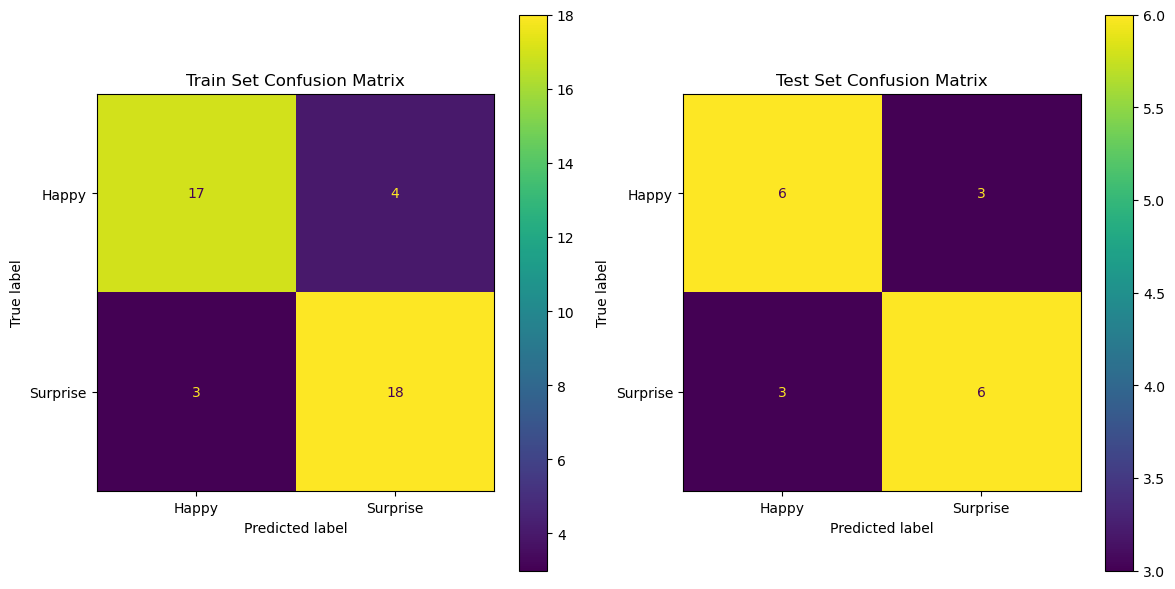

In [41]:
# Train logistic regression
clf = LogisticRegression(max_iter=500, random_state=42)
clf.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_train = clf.predict(X_train_features)
y_pred_test = clf.predict(X_test_features)

# Plot confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_train, display_labels=["Happy", "Surprise"]).plot(ax=ax[0])
ax[0].set_title("Train Set Confusion Matrix")

ConfusionMatrixDisplay(cm_test, display_labels=["Happy", "Surprise"]).plot(ax=ax[1])
ax[1].set_title("Test Set Confusion Matrix")

print("Accuracy on Train")
print(classification_report(y_train, y_pred_train))

print("Accuracy on Test")
print(classification_report(y_test, y_pred_test))

plt.tight_layout()
plt.show()

Accuracy on Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        21
           1       1.00      1.00      1.00        21

    accuracy                           1.00        42
   macro avg       1.00      1.00      1.00        42
weighted avg       1.00      1.00      1.00        42

Accuracy on Test
              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.88      0.78      0.82         9

    accuracy                           0.83        18
   macro avg       0.84      0.83      0.83        18
weighted avg       0.84      0.83      0.83        18



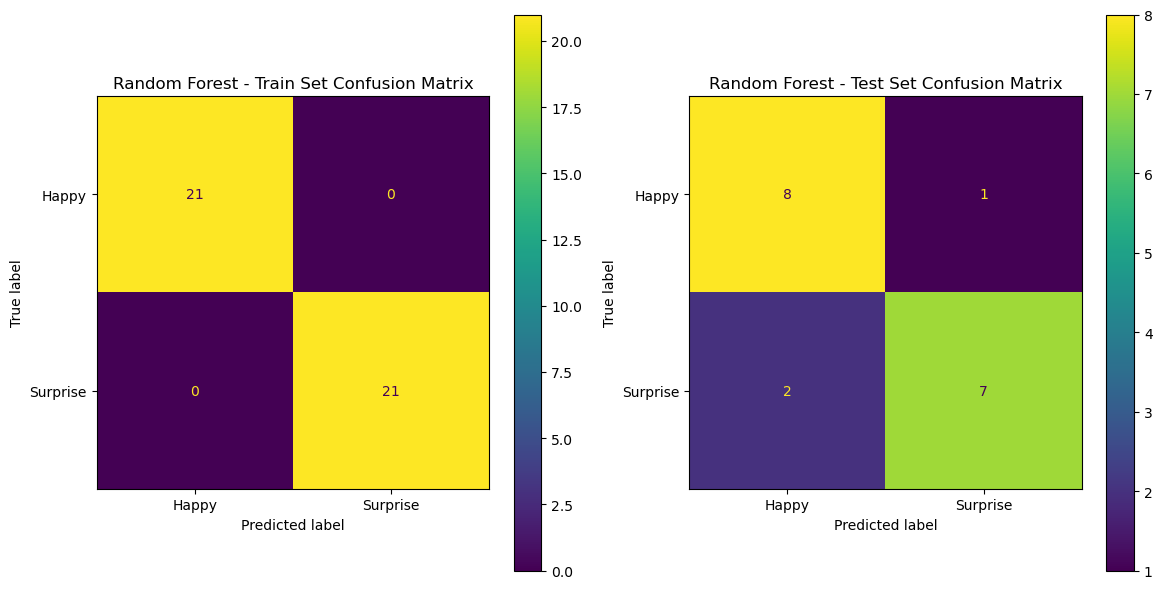

In [42]:
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_train_rf = rf_clf.predict(X_train_features)
y_pred_test_rf = rf_clf.predict(X_test_features)

# Plot confusion matrix for Random Forest
cm_train_rf = confusion_matrix(y_train, y_pred_train_rf)
cm_test_rf = confusion_matrix(y_test, y_pred_test_rf)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_train_rf, display_labels=["Happy", "Surprise"]).plot(ax=ax[0])
ax[0].set_title("Random Forest - Train Set Confusion Matrix")

ConfusionMatrixDisplay(cm_test_rf, display_labels=["Happy", "Surprise"]).plot(ax=ax[1])
ax[1].set_title("Random Forest - Test Set Confusion Matrix")

print("Accuracy on Train")
print(classification_report(y_train, y_pred_train_rf))

print("Accuracy on Test")
print(classification_report(y_test, y_pred_test_rf))

plt.tight_layout()
plt.show()

Accuracy on Train
              precision    recall  f1-score   support

           0       0.73      0.76      0.74        21
           1       0.75      0.71      0.73        21

    accuracy                           0.74        42
   macro avg       0.74      0.74      0.74        42
weighted avg       0.74      0.74      0.74        42

Accuracy on Test
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.57      0.44      0.50         9

    accuracy                           0.56        18
   macro avg       0.56      0.56      0.55        18
weighted avg       0.56      0.56      0.55        18



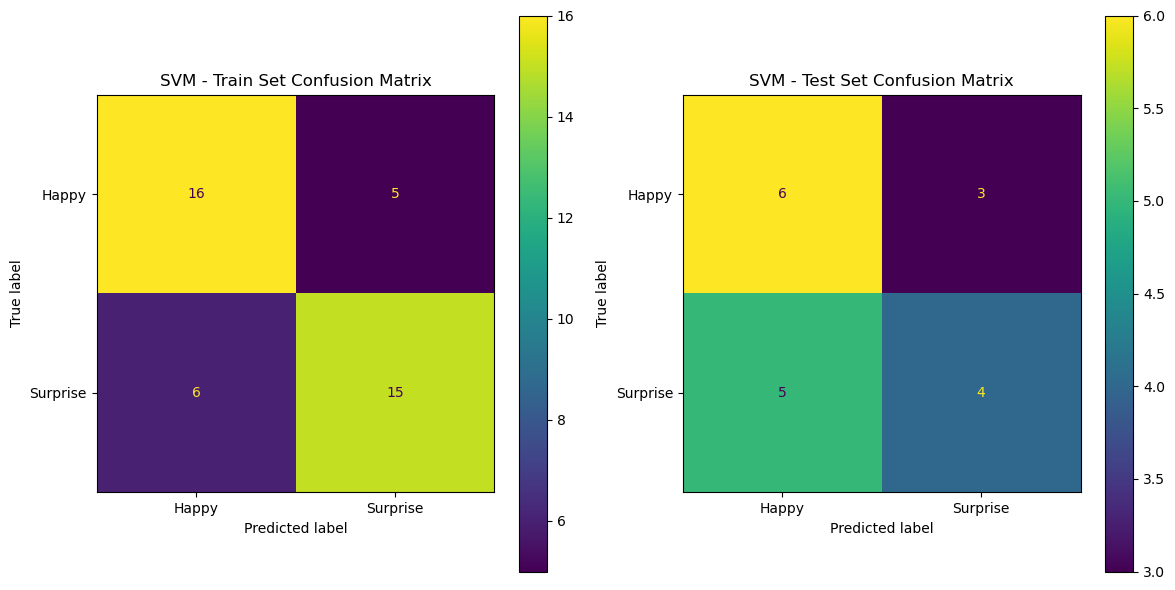

In [45]:
# Train SVM with a linear kernel
svm_clf = SVC(kernel='linear', C=1, random_state=42)
svm_clf.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_train_svm = svm_clf.predict(X_train_features)
y_pred_test_svm = svm_clf.predict(X_test_features)

# Plot confusion matrix for SVM
cm_train_svm = confusion_matrix(y_train, y_pred_train_svm)
cm_test_svm = confusion_matrix(y_test,y_pred_test_svm)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_train_svm, display_labels=["Happy", "Surprise"]).plot(ax=ax[0])
ax[0].set_title("SVM - Train Set Confusion Matrix")

ConfusionMatrixDisplay(cm_test_svm, display_labels=["Happy", "Surprise"]).plot(ax=ax[1])
ax[1].set_title("SVM - Test Set Confusion Matrix")

print("Accuracy on Train")
print(classification_report(y_train, y_pred_train_svm))

print("Accuracy on Test")
print(classification_report(y_test, y_pred_test_svm))

plt.tight_layout()
plt.show()

Accuracy on Train
              precision    recall  f1-score   support

           0       0.88      0.67      0.76        21
           1       0.73      0.90      0.81        21

    accuracy                           0.79        42
   macro avg       0.80      0.79      0.78        42
weighted avg       0.80      0.79      0.78        42

Accuracy on Test
              precision    recall  f1-score   support

           0       0.60      0.67      0.63         9
           1       0.62      0.56      0.59         9

    accuracy                           0.61        18
   macro avg       0.61      0.61      0.61        18
weighted avg       0.61      0.61      0.61        18



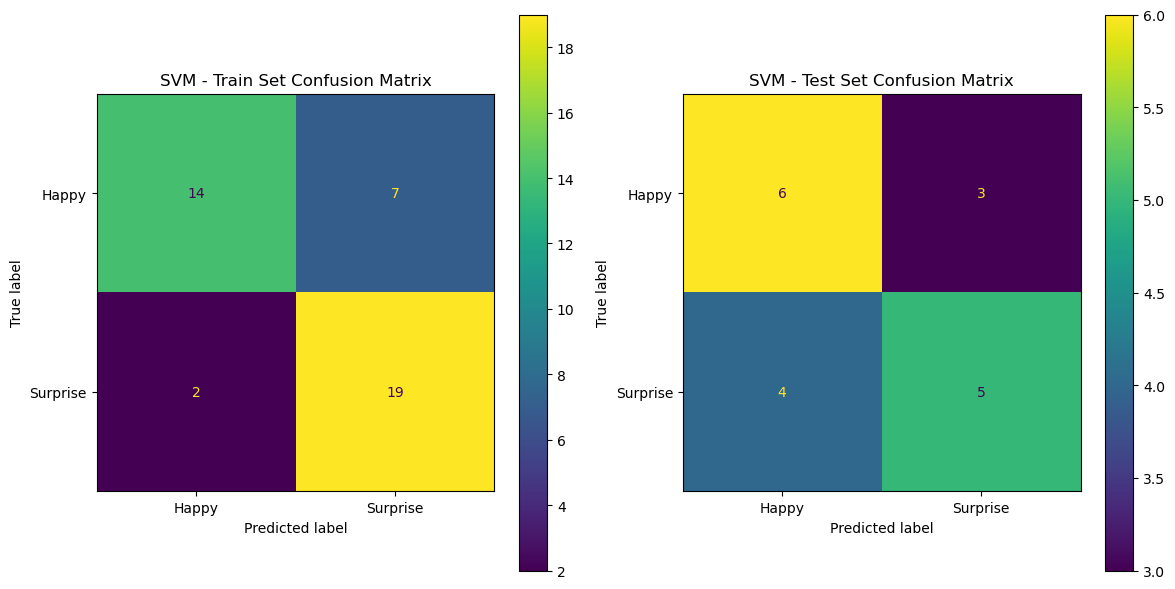

In [ ]:
# Train SVM with a rbf kernel
svm_clf = SVC(kernel='rbf', C=0.1, random_state=42)
svm_clf.fit(X_train_features, y_train)

# Predict and evaluate
y_pred_train_svm = svm_clf.predict(X_train_features)
y_pred_test_svm = svm_clf.predict(X_test_features)

# Plot confusion matrix for SVM
cm_train_svm = confusion_matrix(y_train, y_pred_train_svm)
cm_test_svm = confusion_matrix(y_test,y_pred_test_svm)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_train_svm, display_labels=["Happy", "Surprise"]).plot(ax=ax[0])
ax[0].set_title("SVM - Train Set Confusion Matrix")

ConfusionMatrixDisplay(cm_test_svm, display_labels=["Happy", "Surprise"]).plot(ax=ax[1])
ax[1].set_title("SVM - Test Set Confusion Matrix")

print("Accuracy on Train")
print(classification_report(y_train, y_pred_train_svm))

print("Accuracy on Test")
print(classification_report(y_test, y_pred_test_svm))

plt.tight_layout()
plt.show()

**Training and Evaluation of Models**

We trained and evaluated four models for video classification: **Logistic Regression**, **Random Forest**, **Linear SVM**, and **SVM with RBF Kernel**. The performance of these models was assessed using metrics such as **accuracy**, **precision**, **recall**, and **F1-score** on both the training and test sets.

---

##### **1. Logistic Regression**
- **Training Performance:**
  - **Accuracy:** 83%  
  - **F1-score (macro):** 0.83  
- **Test Performance:**
  - **Accuracy:** 67%  
  - **F1-score (macro):** 0.67  

**Analysis:** Logistic Regression performed moderately well on the training set but struggled to generalize on the test set, indicating potential overfitting.

---

##### **2. Random Forest**
- **Training Performance:**
  - **Accuracy:** 100%  
  - **F1-score (macro):** 1.00  
- **Test Performance:**
  - **Accuracy:** 83%  
  - **F1-score (macro):** 0.83  

**Analysis:** Random Forest achieved perfect performance on the training set and demonstrated good generalization with the highest test accuracy, making it the best-performing model overall.

---

##### **3. Linear SVM**
- **Training Performance:**
  - **Accuracy:** 74%  
  - **F1-score (macro):** 0.74  
- **Test Performance:**
  - **Accuracy:** 56%  
  - **F1-score (macro):** 0.55  

**Analysis:** The Linear SVM struggled to perform well on both the training and test sets, likely due to the inability of the linear kernel to capture the complexity of the features.

---

##### **4. SVM with RBF Kernel**
- **Training Performance:**
  - **Accuracy:** 79%  
  - **F1-score (macro):** 0.78  
- **Test Performance:**
  - **Accuracy:** 61%  
  - **F1-score (macro):** 0.61  

**Analysis:** While the RBF kernel showed improvement over the linear kernel, the model still underperformed on both training and test sets compared to Random Forest, suggesting that feature complexity alone might not be sufficient without better parameter tuning.

---

##### **Summary of Results**

| Model               | Train Accuracy | Test Accuracy | F1-score (Train) | F1-score (Test) |
|---------------------|----------------|---------------|------------------|-----------------|
| Logistic Regression | 83%            | 67%           | 0.83             | 0.67            |
| Random Forest       | 100%           | 83%           | 1.00             | 0.83            |
| Linear SVM          | 74%            | 56%           | 0.74             | 0.55            |
| SVM (RBF Kernel)    | 79%            | 61%           | 0.78             | 0.61            |
